In [1]:
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from nltk.tokenize import word_tokenize, sent_tokenize
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import gensim
plt.style.use('ggplot')

In [7]:
df=pd.read_csv(r"C:\Users\chriq\OneDrive\Documents\my_data\Textminingdata\text_financial\minutes_spy.csv", parse_dates=['date'])

In [8]:
df

,Unnamed: 0,date,contents,speaker,title,SPY: d-1,SPY: d+0,SPY: d+1,SPY: d+2,SPY: d+3,...,SPY: d+5,SPY: d+6,SPY: d+7,SPY: d+8,SPY: d+9,SPY: d+10,SPY: d+11,SPY: d+12,SPY: d+13,SPY: d+14
0,0,1993-02-03,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,25.864319,26.137705,26.247076,26.228842,26.228842,...,26.083029,26.210615,26.010128,25.353931,25.335707,25.317488,25.408623,25.499762,25.481527,25.809631
1,1,1993-03-23,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,26.242840,26.297781,26.297781,26.462601,26.316103,...,26.499220,26.480902,26.389343,25.839956,25.968130,25.894896,25.986469,25.949833,26.316103,26.371027
2,2,1993-05-18,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,25.876574,25.858263,26.389343,26.462601,26.224524,...,26.389343,26.718983,26.627411,26.499220,26.755627,26.718983,26.627411,26.535849,26.444286,26.206215
3,3,1993-07-07,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,26.096848,26.170630,26.465719,26.539494,26.521049,...,26.594809,26.484146,26.410383,26.391937,26.465719,26.447269,26.262844,26.391937,26.539494,26.521049
4,4,1993-08-17,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,26.779249,26.871473,27.019001,27.019001,27.037451,...,27.277197,27.295652,27.314091,27.295652,27.406319,27.480087,27.443205,27.350975,27.369415,27.184986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,219,2021-07-28,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Meeting Minutes,436.076019,435.897217,437.705048,435.579346,434.665497,...,436.046234,438.807648,439.532745,439.175140,439.721466,440.814148,442.135254,442.939850,443.982819,441.072418
220,220,2021-09-22,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Meeting Minutes,432.111908,436.327057,441.628448,442.355896,441.090363,...,432.929016,427.637634,432.719757,427.139374,431.583740,433.377441,437.124268,436.327057,433.168182,432.101929
221,221,2021-11-03,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Meeting Minutes,460.282898,463.093048,465.275391,466.889709,467.288300,...,461.996887,462.146362,465.634094,465.793549,467.637085,466.501099,468.085510,467.248474,465.933075,466.550903
222,222,2021-12-15,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Meeting Minutes,461.737793,468.952454,464.816986,459.869995,454.980011,...,467.690002,470.600006,477.260010,476.869995,477.480011,476.160004,474.959991,477.709991,477.549988,468.380005


In [9]:
# Add a key for aggregation
df['key'] = df.index.get_level_values(0)
df.head()

,Unnamed: 0,date,contents,speaker,title,SPY: d-1,SPY: d+0,SPY: d+1,SPY: d+2,SPY: d+3,...,SPY: d+6,SPY: d+7,SPY: d+8,SPY: d+9,SPY: d+10,SPY: d+11,SPY: d+12,SPY: d+13,SPY: d+14,key
0,0,1993-02-03,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,25.864319,26.137705,26.247076,26.228842,26.228842,...,26.210615,26.010128,25.353931,25.335707,25.317488,25.408623,25.499762,25.481527,25.809631,0
1,1,1993-03-23,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,26.242840,26.297781,26.297781,26.462601,26.316103,...,26.480902,26.389343,25.839956,25.968130,25.894896,25.986469,25.949833,26.316103,26.371027,1
2,2,1993-05-18,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,25.876574,25.858263,26.389343,26.462601,26.224524,...,26.718983,26.627411,26.499220,26.755627,26.718983,26.627411,26.535849,26.444286,26.206215,2
3,3,1993-07-07,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,26.096848,26.170630,26.465719,26.539494,26.521049,...,26.484146,26.410383,26.391937,26.465719,26.447269,26.262844,26.391937,26.539494,26.521049,3
4,4,1993-08-17,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,26.779249,26.871473,27.019001,27.019001,27.037451,...,27.295652,27.314091,27.295652,27.406319,27.480087,27.443205,27.350975,27.369415,27.184986,4


In [10]:
df['contents'] = df['contents'].apply(lambda x: x.replace('\n\n[SECTION]\n\n', '').replace('\n', ' ').replace('\r', ' ').strip())
df

,Unnamed: 0,date,contents,speaker,title,SPY: d-1,SPY: d+0,SPY: d+1,SPY: d+2,SPY: d+3,...,SPY: d+6,SPY: d+7,SPY: d+8,SPY: d+9,SPY: d+10,SPY: d+11,SPY: d+12,SPY: d+13,SPY: d+14,key
0,0,1993-02-03,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,25.864319,26.137705,26.247076,26.228842,26.228842,...,26.210615,26.010128,25.353931,25.335707,25.317488,25.408623,25.499762,25.481527,25.809631,0
1,1,1993-03-23,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,26.242840,26.297781,26.297781,26.462601,26.316103,...,26.480902,26.389343,25.839956,25.968130,25.894896,25.986469,25.949833,26.316103,26.371027,1
2,2,1993-05-18,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,25.876574,25.858263,26.389343,26.462601,26.224524,...,26.718983,26.627411,26.499220,26.755627,26.718983,26.627411,26.535849,26.444286,26.206215,2
3,3,1993-07-07,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,26.096848,26.170630,26.465719,26.539494,26.521049,...,26.484146,26.410383,26.391937,26.465719,26.447269,26.262844,26.391937,26.539494,26.521049,3
4,4,1993-08-17,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,26.779249,26.871473,27.019001,27.019001,27.037451,...,27.295652,27.314091,27.295652,27.406319,27.480087,27.443205,27.350975,27.369415,27.184986,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,219,2021-07-28,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Meeting Minutes,436.076019,435.897217,437.705048,435.579346,434.665497,...,438.807648,439.532745,439.175140,439.721466,440.814148,442.135254,442.939850,443.982819,441.072418,219
220,220,2021-09-22,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Meeting Minutes,432.111908,436.327057,441.628448,442.355896,441.090363,...,427.637634,432.719757,427.139374,431.583740,433.377441,437.124268,436.327057,433.168182,432.101929,220
221,221,2021-11-03,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Meeting Minutes,460.282898,463.093048,465.275391,466.889709,467.288300,...,462.146362,465.634094,465.793549,467.637085,466.501099,468.085510,467.248474,465.933075,466.550903,221
222,222,2021-12-15,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Meeting Minutes,461.737793,468.952454,464.816986,459.869995,454.980011,...,470.600006,477.260010,476.869995,477.480011,476.160004,474.959991,477.709991,477.549988,468.380005,222


# Split the data by sentence, to perform sentiment analysis on short texts

In [11]:
def split_df(df, text_column='contents'):
    '''
    Returns a dataframe which is an extension of an input dataframe.
    Each row in the new dataframe has less than $split_len words in 'text'.
    '''
    split_data_list = []

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        #print("Original Word Count: ", row['word_count'])
        text_list = sent_tokenize(row[text_column])
        for text in text_list:
            row['text'] = text
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            split_data_list.append(list(row))
            
    
    split_df = pd.DataFrame(split_data_list, columns=df.columns.tolist()+['text','word_count'])

    return split_df
df_for_keys = split_df(df)
print(df_for_keys.shape)

<ipython-input-11-fe62b2e1da78>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, row in tqdm(df.iterrows(), total=df.shape[0]):


  0%|          | 0/224 [00:00<?, ?it/s]

(40265, 24)


In [14]:
df_for_keys.text.iloc[0]

'A meeting of the Federal Open Market Committee was held in       the offices of the Board of Governors of the Federal Reserve System in       Washington, D.C., on Tuesday, February 2, 1993, at 2:30 p.m. and was       continued on Wednesday, February 3, 1993, at 9:00 a.m.PRESENT:Mr. Greenspan, Chairman        Mr. Corrigan, Vice Chairman        Mr. Angell        Mr. Boehne        Mr. Keehn        Mr. Kelley        Mr. LaWare        Mr. Lindsey        Mr. McTeer        Mr. Mullins        Ms. Phillips        Mr. SternMessrs.'

In [16]:
df_for_keys.head()

,Unnamed: 0,date,contents,speaker,title,SPY: d-1,SPY: d+0,SPY: d+1,SPY: d+2,SPY: d+3,...,SPY: d+8,SPY: d+9,SPY: d+10,SPY: d+11,SPY: d+12,SPY: d+13,SPY: d+14,key,text,word_count
0,0,1993-02-03,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,25.864319,26.137705,26.247076,26.228842,26.228842,...,25.353931,25.335707,25.317488,25.408623,25.499762,25.481527,25.809631,0,A meeting of the Federal Open Market Committee...,70
1,0,1993-02-03,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,25.864319,26.137705,26.247076,26.228842,26.228842,...,25.353931,25.335707,25.317488,25.408623,25.499762,25.481527,25.809631,0,"Broaddus, Jordan, Forrestal, and Parry, Altern...",13
2,0,1993-02-03,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,25.864319,26.137705,26.247076,26.228842,26.228842,...,25.353931,25.335707,25.317488,25.408623,25.499762,25.481527,25.809631,0,"Hoenig, Melzer, and Syron, Presidents of the F...",18
3,0,1993-02-03,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,25.864319,26.137705,26.247076,26.228842,26.228842,...,25.353931,25.335707,25.317488,25.408623,25.499762,25.481527,25.809631,0,"Kohn, Secretary and Economist Mr. Berna...",31
4,0,1993-02-03,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,25.864319,26.137705,26.247076,26.228842,26.228842,...,25.353931,25.335707,25.317488,25.408623,25.499762,25.481527,25.809631,0,"R. Davis, Lang, Lindsey, Promisel, Rose...",13


# Download Bert for sentiment analysis

In [20]:
import torch
# Load a BERT model, which was trained by another Financial Texts
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
#model.load_state_dict(torch.load('finphrase_bert_trained.dict', map_location=torch.device('cpu')))
model.eval()
model.to("cpu")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Predict sentiment for every sentence
### Define Encoder, Model and Prediction functions

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def bert_encoder(text, max_len=48):
    """ Return embedded text vector as a list in max_len with a mask list"""
    text_token = tokenizer.tokenize(text)
    text_token = text_token[:max_len-2]
    text_token = ["[CLS]"] + text_token + ["[SEP]"]
    text_ids = tokenizer.convert_tokens_to_ids(text_token)
    text_ids += [0] * (max_len - len(text_token))
    pad_masks = [1] * len(text_token) + [0] * (max_len - len(text_token))
    segment_ids = [0] * len(text_token) + [0] * (max_len - len(text_token))
    
    return text_ids, pad_masks, segment_ids

In [22]:
def predict(text, model):
    """ 
    Make a prediction on a single sentence.
    Parameters
    ----------
        text : The string to make a prediction on.
        model : The model to use for making the prediction.
    Returns
    -------
        pred : Prediction vector
    """        
    text_ids, pad_masks, segment_ids = bert_encoder(text)
    
    text_ids = torch.tensor(text_ids).unsqueeze(0)
    pad_masks = torch.tensor(pad_masks).unsqueeze(0)
    segment_ids = torch.tensor(segment_ids).unsqueeze(0)

    outputs = model(text_ids, pad_masks, segment_ids)[0].detach()    
    pred = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
    
    return pred

In [23]:
# Check
text = "Google is working on self driving cars, I'm bullish on $goog"
predict(text,model)

array([[0.37104186, 0.25222972, 0.3767284 ]], dtype=float32)

In [24]:
def score_text(df, text_column, model):
    class_names = ['Negative', 'Neutral', 'Positive']
    scores = []
    predicts = []
    
    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        score = predict(row[text_column], model)
        scores.append((score[0]))
        predicts.append(class_names[int(np.argmax(score))])

    df['score'] = scores
    df['prediction'] = predicts
    
    return df

### Run Prediction

In [25]:
result_df = pd.DataFrame([], columns=df_for_keys.columns)
train_sample = df_for_keys
res = score_text(train_sample, 'text', model)
result_df = pd.concat([result_df, res], axis=0)

result_df.head()

<ipython-input-24-0ffad9f17d21>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, row in tqdm(df.iterrows(), total=df.shape[0]):


  0%|          | 0/40265 [00:00<?, ?it/s]

,Unnamed: 0,date,contents,speaker,title,SPY: d-1,SPY: d+0,SPY: d+1,SPY: d+2,SPY: d+3,...,SPY: d+10,SPY: d+11,SPY: d+12,SPY: d+13,SPY: d+14,key,text,word_count,score,prediction
0,0,1993-02-03 00:00:00,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,25.864319,26.137705,26.247076,26.228842,26.228842,...,25.317488,25.408623,25.499762,25.481527,25.809631,0,A meeting of the Federal Open Market Committee...,70,"[0.30222112, 0.21968311, 0.47809577]",Positive
1,0,1993-02-03 00:00:00,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,25.864319,26.137705,26.247076,26.228842,26.228842,...,25.317488,25.408623,25.499762,25.481527,25.809631,0,"Broaddus, Jordan, Forrestal, and Parry, Altern...",13,"[0.34464908, 0.22800963, 0.4273413]",Positive
2,0,1993-02-03 00:00:00,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,25.864319,26.137705,26.247076,26.228842,26.228842,...,25.317488,25.408623,25.499762,25.481527,25.809631,0,"Hoenig, Melzer, and Syron, Presidents of the F...",18,"[0.36752856, 0.22170328, 0.4107682]",Positive
3,0,1993-02-03 00:00:00,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,25.864319,26.137705,26.247076,26.228842,26.228842,...,25.317488,25.408623,25.499762,25.481527,25.809631,0,"Kohn, Secretary and Economist Mr. Berna...",31,"[0.3369393, 0.21676272, 0.44629797]",Positive
4,0,1993-02-03 00:00:00,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,25.864319,26.137705,26.247076,26.228842,26.228842,...,25.317488,25.408623,25.499762,25.481527,25.809631,0,"R. Davis, Lang, Lindsey, Promisel, Rose...",13,"[0.31372148, 0.22339149, 0.46288702]",Positive


In [26]:
result_df.prediction.value_counts()

Positive    37077
Negative     3123
Neutral        65
Name: prediction, dtype: int64

In [27]:
result_df = pd.concat([result_df, pd.get_dummies(result_df['prediction'])], axis=1)
result_df.head()

,Unnamed: 0,date,contents,speaker,title,SPY: d-1,SPY: d+0,SPY: d+1,SPY: d+2,SPY: d+3,...,SPY: d+13,SPY: d+14,key,text,word_count,score,prediction,Negative,Neutral,Positive
0,0,1993-02-03 00:00:00,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,25.864319,26.137705,26.247076,26.228842,26.228842,...,25.481527,25.809631,0,A meeting of the Federal Open Market Committee...,70,"[0.30222112, 0.21968311, 0.47809577]",Positive,0,0,1
1,0,1993-02-03 00:00:00,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,25.864319,26.137705,26.247076,26.228842,26.228842,...,25.481527,25.809631,0,"Broaddus, Jordan, Forrestal, and Parry, Altern...",13,"[0.34464908, 0.22800963, 0.4273413]",Positive,0,0,1
2,0,1993-02-03 00:00:00,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,25.864319,26.137705,26.247076,26.228842,26.228842,...,25.481527,25.809631,0,"Hoenig, Melzer, and Syron, Presidents of the F...",18,"[0.36752856, 0.22170328, 0.4107682]",Positive,0,0,1
3,0,1993-02-03 00:00:00,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,25.864319,26.137705,26.247076,26.228842,26.228842,...,25.481527,25.809631,0,"Kohn, Secretary and Economist Mr. Berna...",31,"[0.3369393, 0.21676272, 0.44629797]",Positive,0,0,1
4,0,1993-02-03 00:00:00,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,25.864319,26.137705,26.247076,26.228842,26.228842,...,25.481527,25.809631,0,"R. Davis, Lang, Lindsey, Promisel, Rose...",13,"[0.31372148, 0.22339149, 0.46288702]",Positive,0,0,1


In [28]:
train_result = df.copy()
train_result['key2'] =  "_" + train_result['key'].map(str)
result_df['key2'] = "_" + result_df['key'].map(str)

neg = result_df.groupby(by=['key2'])['Negative'].sum()
neu = result_df.groupby(by=['key2'])['Neutral'].sum()
pos = result_df.groupby(by=['key2'])['Positive'].sum()

train_result = train_result.merge(neg, on='key2', how='left')
train_result = train_result.merge(neu, on='key2', how='left')
train_result = train_result.merge(pos, on='key2', how='left')

train_result['sentiment'] = (train_result['Positive'] - train_result['Negative'])


print("The number of records: ", train_result.shape[0])
print("Sentiment is null: ", train_result['sentiment'].isnull().sum())
train_result.tail()

The number of records:  224
Sentiment is null:  0


,Unnamed: 0,date,contents,speaker,title,SPY: d-1,SPY: d+0,SPY: d+1,SPY: d+2,SPY: d+3,...,SPY: d+11,SPY: d+12,SPY: d+13,SPY: d+14,key,key2,Negative,Neutral,Positive,sentiment
219,219,2021-07-28,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Meeting Minutes,436.076019,435.897217,437.705048,435.579346,434.665497,...,442.135254,442.939850,443.982819,441.072418,219,_219,12,0,245.0,233.0
220,220,2021-09-22,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Meeting Minutes,432.111908,436.327057,441.628448,442.355896,441.090363,...,437.124268,436.327057,433.168182,432.101929,220,_220,13,1,217.0,204.0
221,221,2021-11-03,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Meeting Minutes,460.282898,463.093048,465.275391,466.889709,467.288300,...,468.085510,467.248474,465.933075,466.550903,221,_221,12,0,193.0,181.0
222,222,2021-12-15,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Meeting Minutes,461.737793,468.952454,464.816986,459.869995,454.980011,...,474.959991,477.709991,477.549988,468.380005,222,_222,16,1,220.0,204.0
223,223,2022-01-26,"The Federal Reserve, the central bank of the U...",other,FOMC Meeting Minutes,434.470001,433.380005,431.239990,441.950012,449.910004,...,449.320007,440.459991,439.019989,446.100006,223,_223,15,0,328.0,313.0


In [29]:
def pct_change_from_day_0(announcement):
    pct_change= (announcement['SPY: d+7']/announcement['SPY: d-1'])-1
    if pct_change>0:
        return 'up'
    else:
        return 'down'

In [30]:
pct_change_from_day_0(df.iloc[141])

'up'

In [31]:
train_result['+7change']=train_result.apply(pct_change_from_day_0,axis=1)

In [32]:
train_result

,Unnamed: 0,date,contents,speaker,title,SPY: d-1,SPY: d+0,SPY: d+1,SPY: d+2,SPY: d+3,...,SPY: d+12,SPY: d+13,SPY: d+14,key,key2,Negative,Neutral,Positive,sentiment,+7change
0,0,1993-02-03,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,25.864319,26.137705,26.247076,26.228842,26.228842,...,25.499762,25.481527,25.809631,0,_0,14,1,251.0,237.0,up
1,1,1993-03-23,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,26.242840,26.297781,26.297781,26.462601,26.316103,...,25.949833,26.316103,26.371027,1,_1,8,0,159.0,151.0,up
2,2,1993-05-18,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,25.876574,25.858263,26.389343,26.462601,26.224524,...,26.535849,26.444286,26.206215,2,_2,9,0,142.0,133.0,up
3,3,1993-07-07,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,26.096848,26.170630,26.465719,26.539494,26.521049,...,26.391937,26.539494,26.521049,3,_3,8,3,200.0,192.0,up
4,4,1993-08-17,A meeting of the Federal Open Market Committee...,Alan Greenspan,FOMC Meeting Minutes,26.779249,26.871473,27.019001,27.019001,27.037451,...,27.350975,27.369415,27.184986,4,_4,16,0,129.0,113.0,up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,219,2021-07-28,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Meeting Minutes,436.076019,435.897217,437.705048,435.579346,434.665497,...,442.939850,443.982819,441.072418,219,_219,12,0,245.0,233.0,up
220,220,2021-09-22,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Meeting Minutes,432.111908,436.327057,441.628448,442.355896,441.090363,...,436.327057,433.168182,432.101929,220,_220,13,1,217.0,204.0,up
221,221,2021-11-03,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Meeting Minutes,460.282898,463.093048,465.275391,466.889709,467.288300,...,467.248474,465.933075,466.550903,221,_221,12,0,193.0,181.0,up
222,222,2021-12-15,"The Federal Reserve, the central bank of the U...",Jerome Powell,FOMC Meeting Minutes,461.737793,468.952454,464.816986,459.869995,454.980011,...,477.709991,477.549988,468.380005,222,_222,16,1,220.0,204.0,up


# Turn the corpus into a valid input for neural network 

In [33]:
def read_corpus(f, tokens_only=False):
        for i, line in enumerate(f):
            tokens = gensim.utils.simple_preprocess(line)
            if tokens_only:
                yield tokens
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

train_corpus = list(read_corpus(train_result.contents))

In [34]:
#session crashed when i ran this, even when I had a GPU connected it didnt seem to use the GPU
from gensim.models.doc2vec import Doc2Vec
model = Doc2Vec(train_corpus, vector_size=200, window=3, min_count=1, workers=4)

In [35]:
def getVecs(model_name, corpus, size):
    vecs = [np.array(model_name[z.tags[0]]).reshape((1, size)) for z in corpus]
    return np.concatenate(vecs)
train_vecs_dm = getVecs(model, train_corpus, 200)

In [36]:
train_result['train_vecs']=train_vecs_dm.tolist()

In [38]:
train_result.sentiment=train_result.sentiment.apply(lambda x: [x])

In [39]:
train_result['nn_input']=train_result.train_vecs+train_result.sentiment

In [40]:
print(train_result.nn_input.iloc[0])

[-0.5601285099983215, -0.3760932385921478, 1.0162559747695923, 0.6502800583839417, -0.5156813263893127, 0.19142290949821472, -0.5348599553108215, -0.17772595584392548, 0.08051764965057373, 0.004891274031251669, 0.8844339847564697, 0.6493668556213379, -0.2019793838262558, 0.195191890001297, -0.001093198312446475, 0.339317262172699, -0.6320745944976807, 0.4862559139728546, 0.05211305990815163, -0.5385010838508606, -0.01109116431325674, -0.07413042336702347, 0.4177572727203369, -0.6048886775970459, 0.3651522099971771, 0.2897302806377411, 0.3584473431110382, 0.47038134932518005, -0.3679873049259186, 0.07823339104652405, -0.006556323729455471, 0.03225163742899895, 1.2805479764938354, -0.39332497119903564, -0.4554027020931244, -0.6183435916900635, -0.21297712624073029, 0.3200002908706665, 0.7440590262413025, -0.07373640686273575, -0.6775131821632385, -0.31370386481285095, -0.32213839888572693, -0.25102970004081726, -0.08019239455461502, 0.14529909193515778, -0.3408982753753662, -0.1629287898

In [41]:
labels=train_result['+7change'].to_numpy()
labels_onehot=pd.get_dummies(labels).values

In [42]:
labels_onehot[:10]

array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0]], dtype=uint8)

In [43]:
train_result.nn_input=np.array(train_result.nn_input)

In [46]:
nn_in=[np.array(i) for i in train_result.nn_input]

In [47]:
nn_in=np.array(nn_in)

In [48]:
nn_in

array([[-5.60128510e-01, -3.76093239e-01,  1.01625597e+00, ...,
        -3.14475559e-02,  1.49657473e-01,  2.37000000e+02],
       [ 1.01954365e+00,  1.62533224e-01, -1.82976067e-01, ...,
         4.43836212e-01, -3.14332396e-01,  1.51000000e+02],
       [ 8.70118439e-02,  1.02623571e-02, -6.71050608e-01, ...,
         7.12051451e-01, -1.41502604e-01,  1.33000000e+02],
       ...,
       [-1.07300925e+00, -3.86228299e+00, -1.12726355e+00, ...,
        -1.46294788e-01, -9.40637469e-01,  1.81000000e+02],
       [-1.17331541e+00, -1.96951377e+00, -9.55235541e-01, ...,
        -7.38263950e-02, -3.83278802e-02,  2.04000000e+02],
       [ 2.65857130e-01, -2.13548350e+00,  7.94670224e-01, ...,
        -8.47769499e-01,  8.59420538e-01,  3.13000000e+02]])

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(nn_in,labels_onehot,train_size=0.9)
print (len(X_train),len(X_test),len(y_train),len(y_test))

201 23 201 23


In [56]:
X_train_m, X_val, y_train_m, y_val = train_test_split(X_train,y_train,train_size=0.9)
print (len(X_train_m),len(X_val),len(y_train_m),len(y_val))

180 21 180 21


# Use the Vectorial representation of the text and the sentiment of the text as input to the neural network 

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from keras.layers import Dense, Dropout, BatchNormalization
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[0],1)))
model.add(Dropout(0.2))
model.add(BatchNormalization())


model.add(LSTM(units = 50))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['accuracy'])

history=model.fit(X_train_m, y_train_m,validation_data=(X_val,y_val), epochs = 30, batch_size = 15)

Epoch 1/30
12/12 [==============================] - 3s 109ms/step - loss: 0.3180 - accuracy: 0.4556 - val_loss: 0.2440 - val_accuracy: 0.7619
Epoch 2/30
12/12 [==============================] - 1s 67ms/step - loss: 0.2983 - accuracy: 0.5000 - val_loss: 0.2330 - val_accuracy: 0.7619
Epoch 3/30
12/12 [==============================] - 1s 65ms/step - loss: 0.2679 - accuracy: 0.6167 - val_loss: 0.2226 - val_accuracy: 0.7619
Epoch 4/30
12/12 [==============================] - 1s 64ms/step - loss: 0.3044 - accuracy: 0.4667 - val_loss: 0.2147 - val_accuracy: 0.7619
Epoch 5/30
12/12 [==============================] - 1s 65ms/step - loss: 0.2685 - accuracy: 0.5556 - val_loss: 0.2104 - val_accuracy: 0.7619
Epoch 6/30
12/12 [==============================] - 1s 64ms/step - loss: 0.2802 - accuracy: 0.5167 - val_loss: 0.2059 - val_accuracy: 0.7619
Epoch 7/30
12/12 [==============================] - 1s 64ms/step - loss: 0.2717 - accuracy: 0.5500 - val_loss: 0.2038 - val_accuracy: 0.7619
Epoch 8/30
1

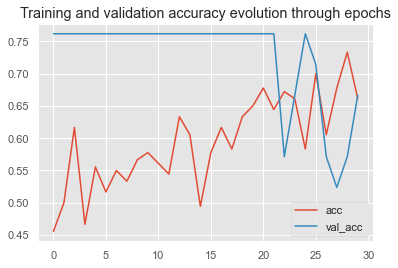

In [59]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Training and validation accuracy evolution through epochs')
plt.legend()
plt.show()

In [61]:
model.evaluate(X_test,y_test)

1/1 [==============================] - 0s 41ms/step - loss: 0.3000 - accuracy: 0.5217


[0.30000609159469604, 0.52173912525177]